In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import seffaflik
seffaflik.Kimlik(istemci_taniticisi="abcdefg")
from seffaflik.elektrik import tuketim

In [3]:
# input reading
consumption_data = tuketim.gerceklesen(baslangic_tarihi='2016-01-01', bitis_tarihi='2020-12-01')
consumption_data.columns = ["Date", "Hour", "Consumption"]
consumption_data.head()

,Date,Hour,Consumption
0,2016-01-01,0,26277.24
1,2016-01-01,1,24991.82
2,2016-01-01,2,23532.61
3,2016-01-01,3,22464.78
4,2016-01-01,4,22002.91


In [4]:
# calculation of lag48 and lag168
consumption_data["Lag_48"] = consumption_data["Consumption"].shift(48)
consumption_data["Lag_168"] = consumption_data["Consumption"].shift(168)
consumption_data.tail()

,Date,Hour,Consumption,Lag_48,Lag_168
43123,2020-12-01,19,40720.16,36310.77,40895.17
43124,2020-12-01,20,39195.74,35383.08,39240.65
43125,2020-12-01,21,38310.79,34491.45,38366.41
43126,2020-12-01,22,37173.97,33698.14,37446.73
43127,2020-12-01,23,35725.46,32295.74,36186.83


In [5]:
check = consumption_data.groupby("Date").apply(lambda x: False if len(x["Hour"].unique()) != 24 else True)
check[check == False]

Date
2016-03-27    False
dtype: bool

In [6]:
ind = check[check == False].index[0]
consumption_data[consumption_data["Date"]==ind]

,Date,Hour,Consumption,Lag_48,Lag_168
2064,2016-03-27,0,27424.42,27911.16,27580.31
2065,2016-03-27,1,25949.63,26381.87,25826.71
2066,2016-03-27,2,0.00,25524.50,24546.43
2067,2016-03-27,4,24776.94,25091.06,23700.46
2068,2016-03-27,4,24776.94,25150.84,23731.69
2069,2016-03-27,5,24098.97,25117.72,23490.68
2070,2016-03-27,6,23267.43,25180.73,22361.72
2071,2016-03-27,7,22531.83,27289.79,22738.71
2072,2016-03-27,8,23398.59,31394.47,24022.10
2073,2016-03-27,9,24969.23,33801.30,25792.17


- There is an error in the 2067<sup>th</sup> row. To prevent misinterpretation, I will drop this week from the data.

In [7]:
# dropping the week
start = int(consumption_data[consumption_data["Date"]=="2016-03-21"].index[0])
consumption_data.drop(consumption_data.index[range(start,2088)],inplace=True)
consumption_data.reset_index(drop=True,inplace=True)

## Task a 
MAPE calculation for naive forecasts with Lag48 and Lag168

In [8]:
# classification to test and train data
test_data = consumption_data[consumption_data["Date"] >= "2020-11-01"].reset_index(drop=True).copy().dropna()
train_data = consumption_data[consumption_data["Date"] < "2020-11-01"].copy().dropna().reset_index(drop=True)
test_data.head()

,Date,Hour,Consumption,Lag_48,Lag_168
0,2020-11-01,0,28701.62,29066.51,29481.33
1,2020-11-01,1,27254.15,27838.89,28002.28
2,2020-11-01,2,26078.57,26940.11,27115.39
3,2020-11-01,3,25449.47,26260.80,26415.11
4,2020-11-01,4,25324.01,26097.96,26075.07


In [9]:
# function for calculation of MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    _abs = np.abs((y_true - y_pred) / y_true)
    return np.mean(_abs) * 100, _abs

In [10]:
# text formatting
from IPython.display import Markdown, display
def printmd(string,color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [91]:
# naive forecasts
nf_48,_abs48 = mean_absolute_percentage_error(test_data["Consumption"], test_data["Lag_48"]) 
nf_168,_abs168 = mean_absolute_percentage_error(test_data["Consumption"], test_data["Lag_168"]) 

mapes48 = []
mapes168 = []
for i in range(24):
    mapes48.append(mean_absolute_percentage_error(test_data[test_data["Hour"]==i]["Consumption"], test_data[test_data["Hour"]==i]["Lag_48"])[0])
    mapes168.append(mean_absolute_percentage_error(test_data[test_data["Hour"]==i]["Consumption"], test_data[test_data["Hour"]==i]["Lag_168"])[0])

printmd("**MAPE for Lag_48:** {}".format(round(nf_48,5)))
printmd("**MAPE for Lag_168:** {}".format(round(nf_168,5)))

<span style='color:None'>**MAPE for Lag_48:** 8.06031</span>

<span style='color:None'>**MAPE for Lag_168:** 3.44919</span>

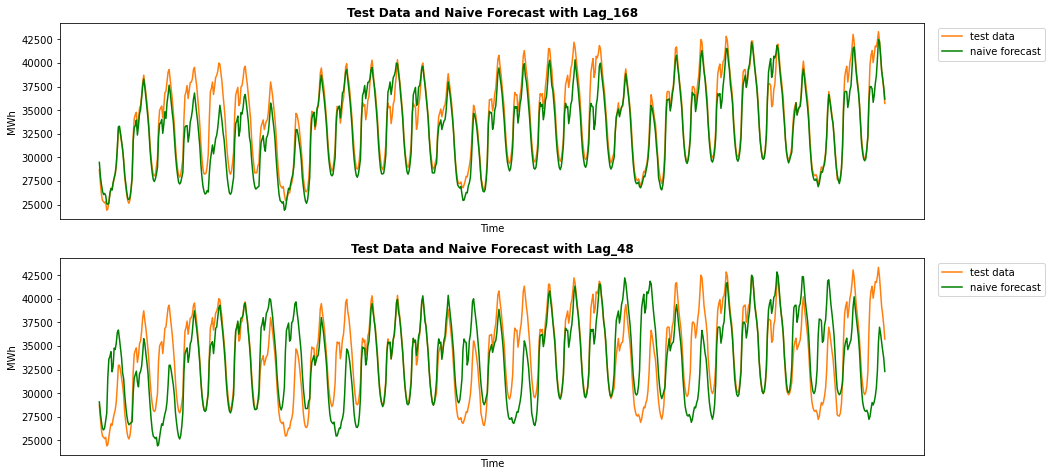

In [12]:
# plotting test data and naive forecasts
fig, axes = plt.subplots(2,1,sharex=True,sharey=True)

axes[0].set_title("Test Data and Naive Forecast with Lag_168",fontweight="bold")
axes[0].plot(np.arange(len(test_data)), test_data["Consumption"], color="tab:orange", label="test data")
axes[0].plot(np.arange(len(test_data)), test_data["Lag_168"], color='g', label="naive forecast") 
axes[0].set_xlabel('Time')
axes[0].set_ylabel('MWh')
axes[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')

axes[1].set_title("Test Data and Naive Forecast with Lag_48",fontweight="bold")
axes[1].plot(np.arange(len(test_data)), test_data["Consumption"], color="tab:orange", label="test data")
axes[1].plot(np.arange(len(test_data)), test_data["Lag_48"], color="g", label="naive forecast")  
axes[1].set_xlabel('Time')
axes[1].set_ylabel('MWh')
plt.xticks([])
axes[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.subplots_adjust(hspace=0.2, top=1.5, bottom=0, left=0, right=2)
plt.show()

| Lag |MAPE |
| :-- | :-: | 
| Lag_48 | 8.06031 | 
| Lag_168 | 3.44919 | 


- As it can be seen in the above graphs and MAPE results, naive forecast with **Lag 168 performs better** than **Lag 48**.
This indicates that weekly relation in consumption is more important than two-day relation.

## Task b:

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
# training linear regression model
model = LinearRegression().fit(train_data[["Lag_48","Lag_168"]].values, train_data["Consumption"].values)

In [15]:
# summary for linear regression model
from regressors import stats
print("\n==================== SUMMARY =======================")
stats.summary(model, train_data[["Lag_48","Lag_168"]], train_data["Consumption"], ["Lag_48","Lag_168"])


==================== SUMMARY =======================
Residuals:
        Min         1Q  Median        3Q         Max
-16095.7567 -1019.2529  0.6228  986.9214  17122.8647


Coefficients:
               Estimate  Std. Error   t value  p value
_intercept  1588.147236   83.729253   18.9677      0.0
Lag_48         0.308522    0.002125  145.1955      0.0
Lag_168        0.643064    0.002125  302.5761      0.0
---
R-squared:  0.77508,    Adjusted R-squared:  0.77507
F-statistic: 72443.10 on 2 features


In [16]:
# predicting consumption values for test data
y_test = test_data["Consumption"].values
y_pred = model.predict(test_data[["Lag_48","Lag_168"]].values )

In [18]:
printmd("**----- Linear Regression Model -----**")
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
linear_mape, _abslinear_mape = mean_absolute_percentage_error(df['Actual'], df['Predicted'])
linear_forecast = _abslinear_mape.tolist()
printmd("**MAPE:**  {}".format(round(linear_mape,5)))

<span style='color:None'>**----- Linear Regression Model -----**</span>

<span style='color:None'>**MAPE:**  4.22863</span>

In [174]:
#linear_mape, linear_forecast = mean_absolute_percentage_error(df['Actual'], df['Predicted'])
#linear_forecast = linear_forecast.tolist()

In [19]:
import seaborn as sns

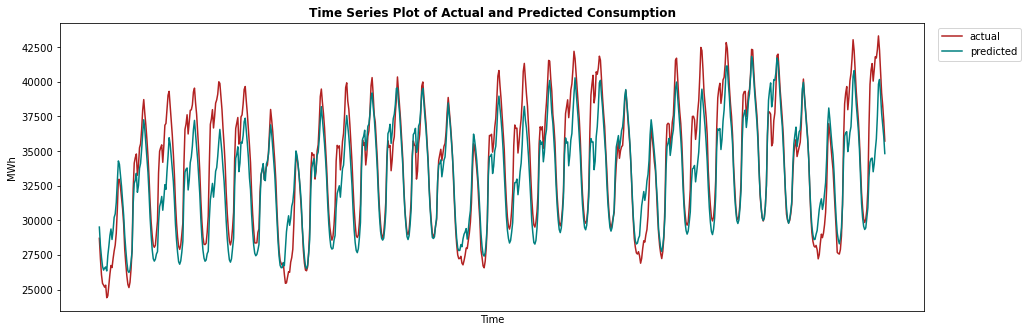

In [20]:
# plotting actual and predicted consumption
fig, axes = plt.subplots(1,1)
axes.set_title("Time Series Plot of Actual and Predicted Consumption",fontweight="bold")
axes.plot(np.arange(len(y_test)), y_test,color="firebrick", label="actual")
axes.plot(np.arange(len(y_test)), y_pred,color="teal", label="predicted") 
axes.set_xlabel('Time')
axes.set_ylabel('MWh')
plt.xticks([])
axes.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.subplots_adjust(hspace=0.1, top=1, bottom=0, left=0, right=2)

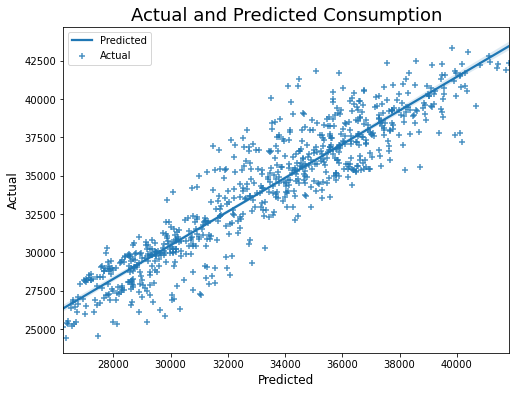

In [22]:
fig = plt.figure(figsize=(8,6))
sns.regplot(x=y_pred,y=y_test, marker='+')
plt.legend(labels=["Predicted","Actual"])
plt.title("Actual and Predicted Consumption", size=18)
plt.xlabel("Predicted", size=12)
plt.ylabel("Actual", size=12);
plt.show()

| Method | MAPE |
| :-- | :-: | 
| Lag_48 | 8.06031 | 
| Lag_168 | 3.44919 | 
| Linear Regression | 4.22959 |

- After two naive forecasts, in this step linear regression is used for predicting consumption values. MAPE value of linear regression is better than naive forecast with Lag 48 but it is worse than naive forecast with Lag 168. Thus, we can say that linear regression performs better than Lag 48 but worse than naive approach with Lag168.

## Task c:

In [23]:
mapes = []

# function for applying linear regression each hour seperately
def hourly_linear_regression(hour):
    hdata_train = train_data[train_data["Hour"]==hour]
    hdata_test = test_data[test_data["Hour"]==hour]
    model = LinearRegression().fit(hdata_train[["Lag_48","Lag_168"]].values, hdata_train["Consumption"].values)
    y_test = hdata_test["Consumption"].values
    y_pred = model.predict(hdata_test[["Lag_48","Lag_168"]].values )
    
    df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
    mean_mape, mape_abs =  mean_absolute_percentage_error(df['Actual'], df['Predicted'])
    
    printmd("**Linear Regression Model for Hour {}**".format(str(hour)),color="firebrick")
    printmd("**Intercept**: {}".format(model.intercept_))
    printmd("**Coefficients**: {}".format(model.coef_))
    printmd("**MAPE:**  {}".format(round(mean_mape,5)))
    visualize(y_test,y_pred)
    return mean_mape
    
def visualize(y_test,y_pred):
    fig = plt.figure()
    plt.title("Time Series Plot of Actual and Predicted Consumption",fontweight="bold")
    plt.plot(np.arange(len(y_test)), y_test,color="firebrick", label="actual")
    plt.plot(np.arange(len(y_test)), y_pred,color="teal", label="predicted") 
    plt.xlabel('Time')
    plt.ylabel('MWh')
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.subplots_adjust(hspace=0.1, top=1, bottom=0, right=1.5)

<span style='color:firebrick'>**Linear Regression Model for Hour 0**</span>

<span style='color:None'>**Intercept**: 2209.5646822756826</span>

<span style='color:None'>**Coefficients**: [0.4869749 0.4422004]</span>

<span style='color:None'>**MAPE:**  3.26298</span>

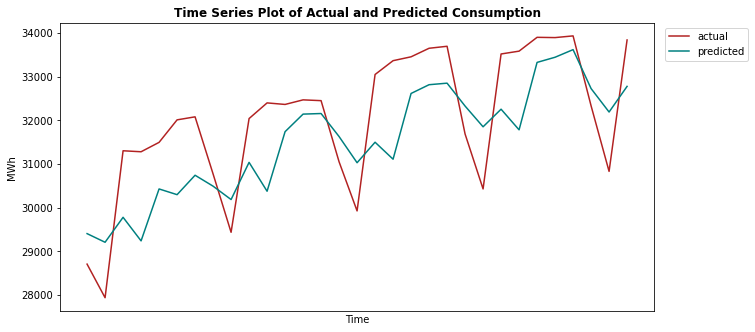

In [24]:
mapes.append(hourly_linear_regression(0))

<span style='color:firebrick'>**Linear Regression Model for Hour 1**</span>

<span style='color:None'>**Intercept**: 2136.1314033478957</span>

<span style='color:None'>**Coefficients**: [0.49220712 0.43567769]</span>

<span style='color:None'>**MAPE:**  3.28371</span>

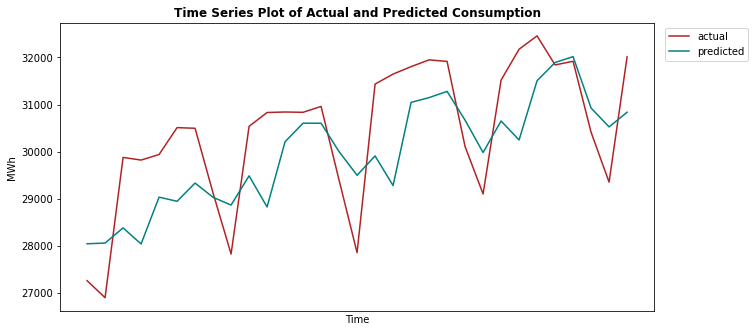

In [25]:
mapes.append(hourly_linear_regression(1))

<span style='color:firebrick'>**Linear Regression Model for Hour 2**</span>

<span style='color:None'>**Intercept**: 3062.1456451280064</span>

<span style='color:None'>**Coefficients**: [0.47403654 0.41895182]</span>

<span style='color:None'>**MAPE:**  3.40851</span>

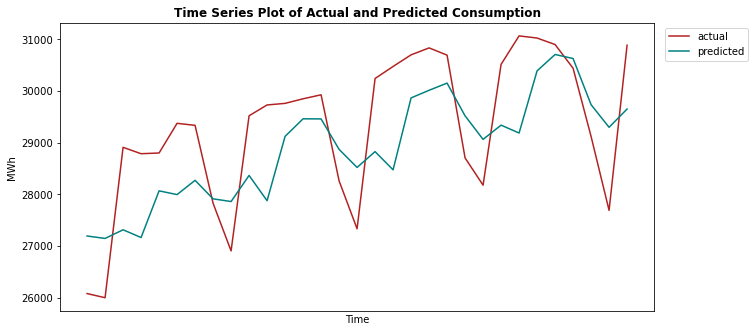

In [26]:
mapes.append(hourly_linear_regression(2))

<span style='color:firebrick'>**Linear Regression Model for Hour 3**</span>

<span style='color:None'>**Intercept**: 2235.9849607840806</span>

<span style='color:None'>**Coefficients**: [0.4931097  0.42640161]</span>

<span style='color:None'>**MAPE:**  3.20381</span>

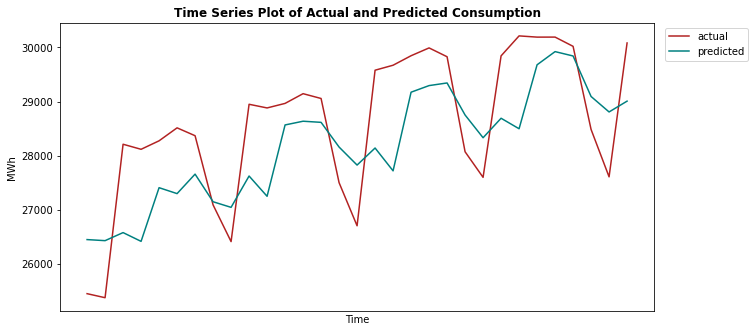

In [27]:
mapes.append(hourly_linear_regression(3))

<span style='color:firebrick'>**Linear Regression Model for Hour 4**</span>

<span style='color:None'>**Intercept**: 2206.9286733835143</span>

<span style='color:None'>**Coefficients**: [0.47505811 0.44451634]</span>

<span style='color:None'>**MAPE:**  3.18375</span>

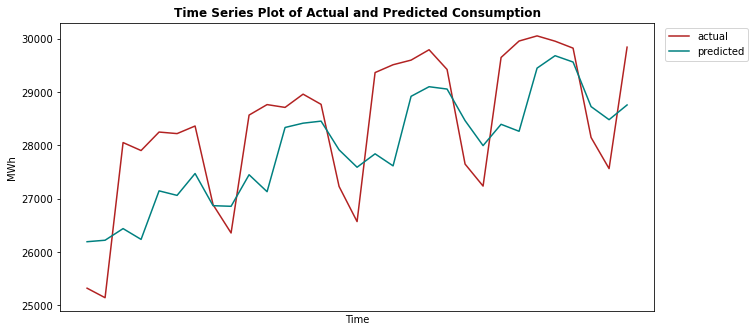

In [28]:
mapes.append(hourly_linear_regression(4))

<span style='color:firebrick'>**Linear Regression Model for Hour 5**</span>

<span style='color:None'>**Intercept**: 2233.7029593406623</span>

<span style='color:None'>**Coefficients**: [0.43998991 0.47803465]</span>

<span style='color:None'>**MAPE:**  3.188</span>

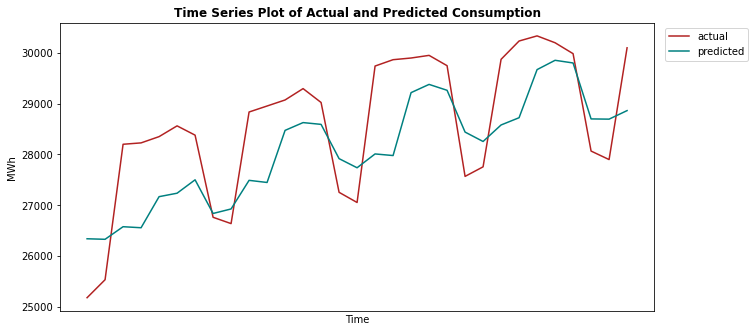

In [29]:
mapes.append(hourly_linear_regression(5))

<span style='color:firebrick'>**Linear Regression Model for Hour 6**</span>

<span style='color:None'>**Intercept**: 2135.6509907477594</span>

<span style='color:None'>**Coefficients**: [0.37617682 0.54570539]</span>

<span style='color:None'>**MAPE:**  3.14862</span>

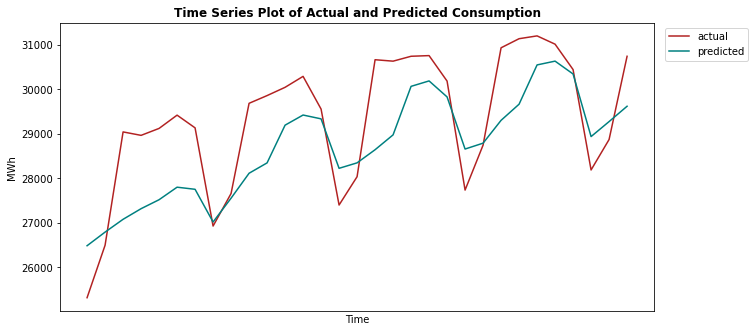

In [30]:
mapes.append(hourly_linear_regression(6))

<span style='color:firebrick'>**Linear Regression Model for Hour 7**</span>

<span style='color:None'>**Intercept**: 2323.0050382183254</span>

<span style='color:None'>**Coefficients**: [0.26668614 0.65208697]</span>

<span style='color:None'>**MAPE:**  3.77564</span>

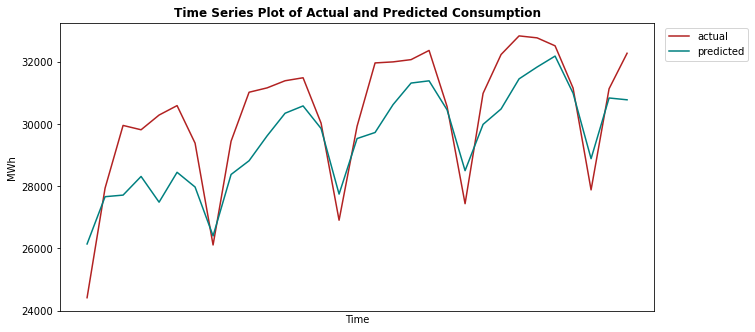

In [31]:
mapes.append(hourly_linear_regression(7))

<span style='color:firebrick'>**Linear Regression Model for Hour 8**</span>

<span style='color:None'>**Intercept**: 3250.2183250892485</span>

<span style='color:None'>**Coefficients**: [0.17395979 0.7248555 ]</span>

<span style='color:None'>**MAPE:**  4.67265</span>

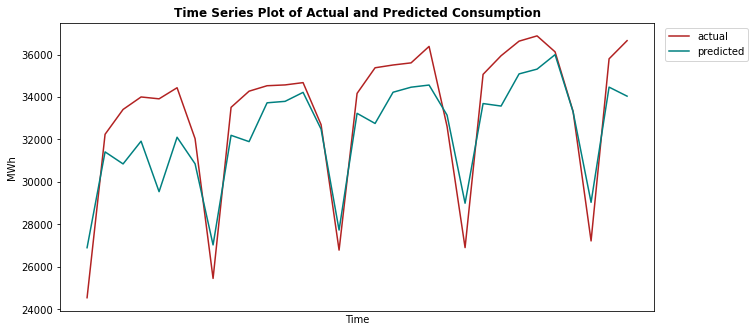

In [32]:
mapes.append(hourly_linear_regression(8))

<span style='color:firebrick'>**Linear Regression Model for Hour 9**</span>

<span style='color:None'>**Intercept**: 3614.4448162502304</span>

<span style='color:None'>**Coefficients**: [0.17455845 0.72001582]</span>

<span style='color:None'>**MAPE:**  5.48662</span>

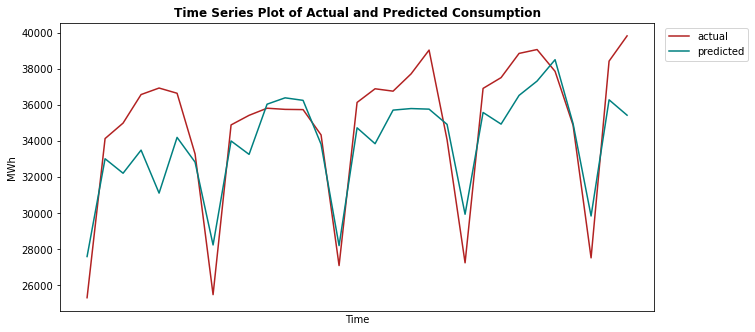

In [33]:
mapes.append(hourly_linear_regression(9))

<span style='color:firebrick'>**Linear Regression Model for Hour 10**</span>

<span style='color:None'>**Intercept**: 3757.418338591924</span>

<span style='color:None'>**Coefficients**: [0.20640338 0.68628773]</span>

<span style='color:None'>**MAPE:**  6.08826</span>

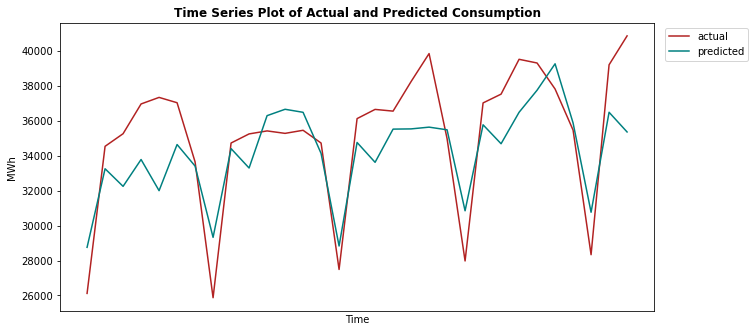

In [34]:
mapes.append(hourly_linear_regression(10))

<span style='color:firebrick'>**Linear Regression Model for Hour 11**</span>

<span style='color:None'>**Intercept**: 3978.1490466941905</span>

<span style='color:None'>**Coefficients**: [0.22503833 0.66310857]</span>

<span style='color:None'>**MAPE:**  6.27326</span>

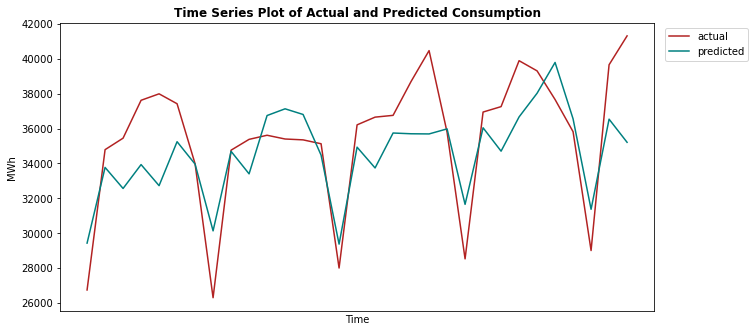

In [35]:
mapes.append(hourly_linear_regression(11))

<span style='color:firebrick'>**Linear Regression Model for Hour 12**</span>

<span style='color:None'>**Intercept**: 3684.282567394461</span>

<span style='color:None'>**Coefficients**: [0.27995917 0.61285282]</span>

<span style='color:None'>**MAPE:**  6.54301</span>

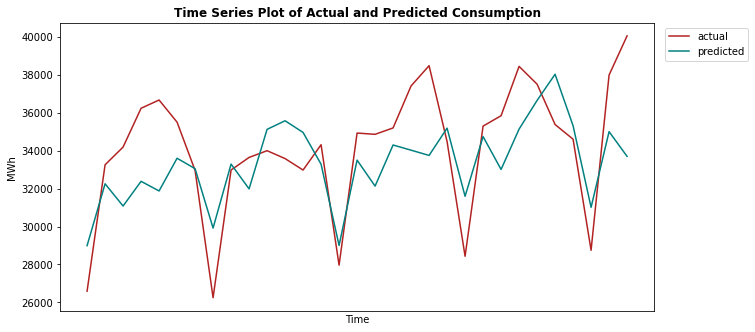

In [36]:
mapes.append(hourly_linear_regression(12))

<span style='color:firebrick'>**Linear Regression Model for Hour 13**</span>

<span style='color:None'>**Intercept**: 3827.424128875493</span>

<span style='color:None'>**Coefficients**: [0.30340098 0.58646178]</span>

<span style='color:None'>**MAPE:**  6.68321</span>

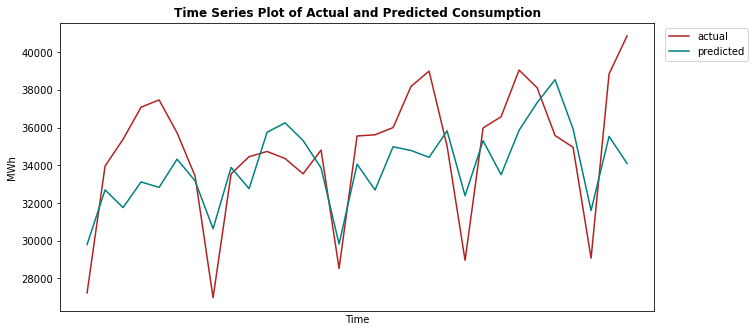

In [37]:
mapes.append(hourly_linear_regression(13))

<span style='color:firebrick'>**Linear Regression Model for Hour 14**</span>

<span style='color:None'>**Intercept**: 4093.2938590587946</span>

<span style='color:None'>**Coefficients**: [0.25948856 0.62516304]</span>

<span style='color:None'>**MAPE:**  6.48007</span>

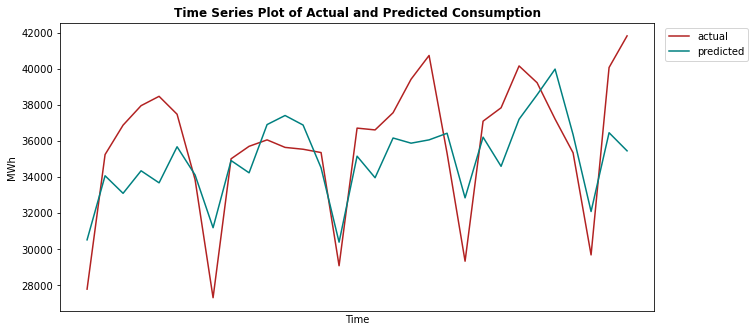

In [38]:
mapes.append(hourly_linear_regression(14))

<span style='color:firebrick'>**Linear Regression Model for Hour 15**</span>

<span style='color:None'>**Intercept**: 3982.1206199906082</span>

<span style='color:None'>**Coefficients**: [0.25607058 0.63150045]</span>

<span style='color:None'>**MAPE:**  6.08148</span>

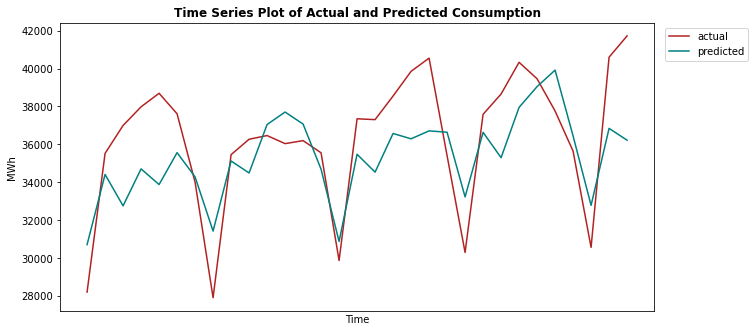

In [39]:
mapes.append(hourly_linear_regression(15))

<span style='color:firebrick'>**Linear Regression Model for Hour 16**</span>

<span style='color:None'>**Intercept**: 3851.0033256561765</span>

<span style='color:None'>**Coefficients**: [0.24676978 0.6451004 ]</span>

<span style='color:None'>**MAPE:**  5.14544</span>

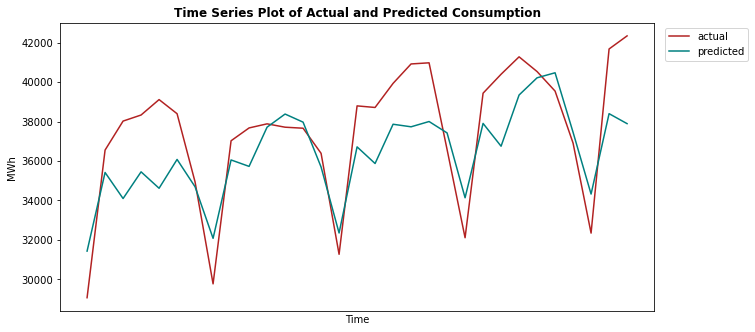

In [40]:
mapes.append(hourly_linear_regression(16))

<span style='color:firebrick'>**Linear Regression Model for Hour 17**</span>

<span style='color:None'>**Intercept**: 3429.449616145561</span>

<span style='color:None'>**Coefficients**: [0.26173697 0.64244716]</span>

<span style='color:None'>**MAPE:**  4.60837</span>

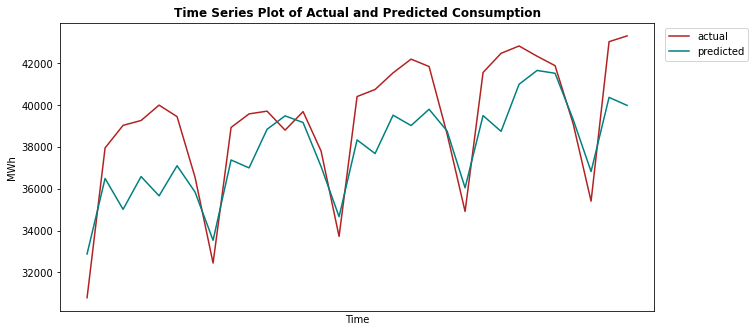

In [41]:
mapes.append(hourly_linear_regression(17))

<span style='color:firebrick'>**Linear Regression Model for Hour 18**</span>

<span style='color:None'>**Intercept**: 3049.441247509112</span>

<span style='color:None'>**Coefficients**: [0.33378356 0.5811446 ]</span>

<span style='color:None'>**MAPE:**  3.73673</span>

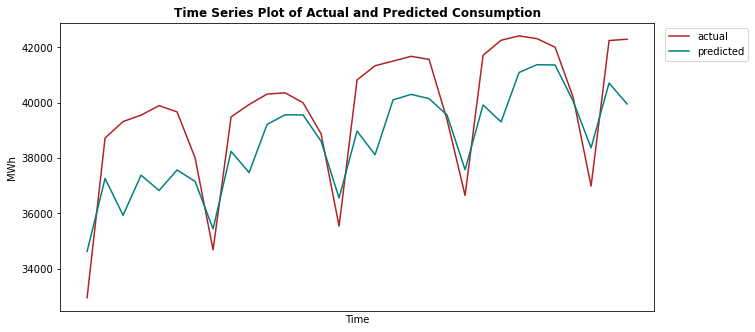

In [42]:
mapes.append(hourly_linear_regression(18))

<span style='color:firebrick'>**Linear Regression Model for Hour 19**</span>

<span style='color:None'>**Intercept**: 3188.86327117747</span>

<span style='color:None'>**Coefficients**: [0.38667825 0.52463163]</span>

<span style='color:None'>**MAPE:**  3.43302</span>

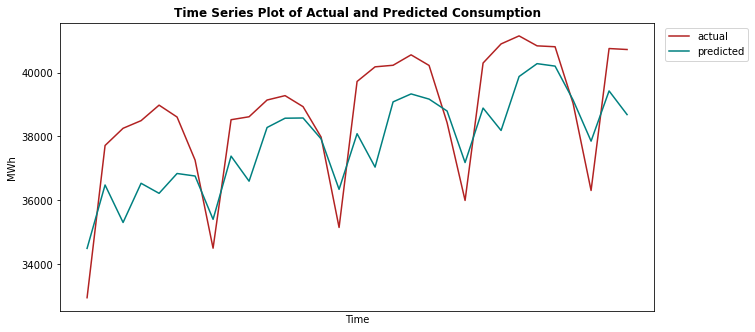

In [43]:
mapes.append(hourly_linear_regression(19))

<span style='color:firebrick'>**Linear Regression Model for Hour 20**</span>

<span style='color:None'>**Intercept**: 2806.18446976415</span>

<span style='color:None'>**Coefficients**: [0.4076442  0.51415198]</span>

<span style='color:None'>**MAPE:**  3.16285</span>

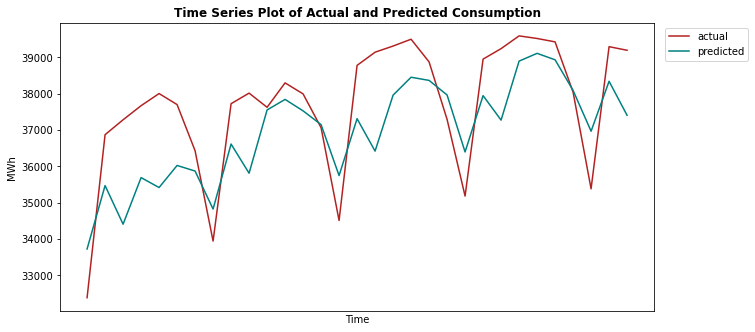

In [44]:
mapes.append(hourly_linear_regression(20))

<span style='color:firebrick'>**Linear Regression Model for Hour 21**</span>

<span style='color:None'>**Intercept**: 2678.4684132090188</span>

<span style='color:None'>**Coefficients**: [0.42876184 0.49522304]</span>

<span style='color:None'>**MAPE:**  3.16478</span>

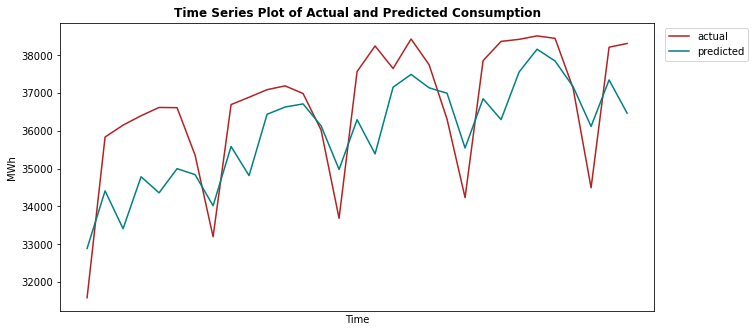

In [45]:
mapes.append(hourly_linear_regression(21))

<span style='color:firebrick'>**Linear Regression Model for Hour 22**</span>

<span style='color:None'>**Intercept**: 2835.2034789354</span>

<span style='color:None'>**Coefficients**: [0.4425247  0.47530873]</span>

<span style='color:None'>**MAPE:**  3.16574</span>

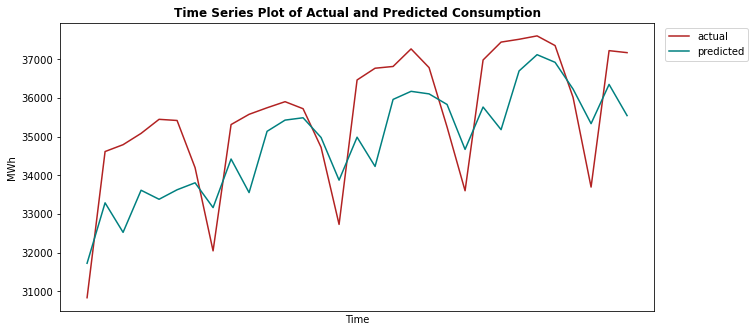

In [46]:
mapes.append(hourly_linear_regression(22))

<span style='color:firebrick'>**Linear Regression Model for Hour 23**</span>

<span style='color:None'>**Intercept**: 2547.5016961741057</span>

<span style='color:None'>**Coefficients**: [0.45098384 0.47196315]</span>

<span style='color:None'>**MAPE:**  3.38602</span>

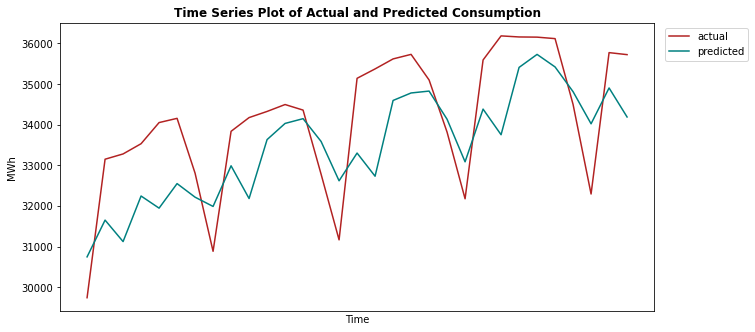

In [47]:
mapes.append(hourly_linear_regression(23))

In [49]:
# all MAPE results
printmd("**MAPE values:**")
for i in range(0,24):
    print("Hour {}: {}".format(str(i),round(mapes[i],5)))

<span style='color:None'>**MAPE values:**</span>

Hour 0: 3.26298
Hour 1: 3.28371
Hour 2: 3.40851
Hour 3: 3.20381
Hour 4: 3.18375
Hour 5: 3.188
Hour 6: 3.14862
Hour 7: 3.77564
Hour 8: 4.67265
Hour 9: 5.48662
Hour 10: 6.08826
Hour 11: 6.27326
Hour 12: 6.54301
Hour 13: 6.68321
Hour 14: 6.48007
Hour 15: 6.08148
Hour 16: 5.14544
Hour 17: 4.60837
Hour 18: 3.73673
Hour 19: 3.43302
Hour 20: 3.16285
Hour 21: 3.16478
Hour 22: 3.16574
Hour 23: 3.38602


| Method | MAPE |
| :-- | :-: | 
| Lag_48 | 8.06031 | 
| Lag_168 | 3.44919 | 
| Linear Regression | 4.22959 |

- Using linear regression for each hour seperately improves MAPE values for hours between (18.00 - 7.00) compared to previous part. 


- Compared to naive forecast with Lag 168, this approach has a better performance for hours between (19.00 - 6.00), and this time period is called *off-peak times* in electricity market, electiricity suppliers tend to charge less price during these hours. But for other periods, this approach does not perform better than part(b) and naive forecast with Lag168.

## Task d:

In [50]:
consumption_data.dropna(inplace=True)
consumption_data.head()

,Date,Hour,Consumption,Lag_48,Lag_168
168,2016-01-08,0,28602.02,29189.27,26277.24
169,2016-01-08,1,27112.37,27614.02,24991.82
170,2016-01-08,2,25975.34,26578.97,23532.61
171,2016-01-08,3,25315.55,25719.19,22464.78
172,2016-01-08,4,25128.15,25864.63,22002.91


In [51]:
# transforming data to wide format
wide_data = consumption_data.pivot_table(index="Date", columns="Hour", values=["Lag_48","Lag_168","Consumption"])
wide_data.columns = ["Lag_day"+str(i)+"_"+"hour"+str(j) for i in (2,7) for j in range(24)] + ["Consumption_"+str(i) for i in range(24)]
wide_data.reset_index(inplace=True)
wide_data.head()

,Date,Lag_day2_hour0,Lag_day2_hour1,Lag_day2_hour2,Lag_day2_hour3,Lag_day2_hour4,Lag_day2_hour5,Lag_day2_hour6,Lag_day2_hour7,Lag_day2_hour8,...,Consumption_14,Consumption_15,Consumption_16,Consumption_17,Consumption_18,Consumption_19,Consumption_20,Consumption_21,Consumption_22,Consumption_23
0,2016-01-08,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
1,2016-01-09,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,37376.83,37100.43,37668.65,37906.99,35841.62,34621.65,33784.72,32638.14,32739.98,31092.87
2,2016-01-10,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,36555.58,36190.41,37031.72,37773.70,35930.69,34710.46,33907.65,33048.69,33220.16,32021.60
3,2016-01-11,27130.75,25403.40,24452.96,23959.85,23839.28,24358.46,25800.81,27336.03,32683.24,...,33524.80,32951.39,33655.89,35045.14,34407.27,33494.32,32624.31,32097.79,32176.63,30760.17
4,2016-01-12,29161.64,27519.24,26256.43,25766.11,25808.92,26222.03,27290.07,28628.67,32817.04,...,29089.83,29447.75,30569.07,32006.15,31706.26,31305.87,30870.26,30462.79,30537.75,28857.66


In [52]:
wide_train_lasso = wide_data[wide_data["Date"]<"2020-11-01"].dropna()
wide_test_lasso = wide_data[wide_data["Date"]>="2020-11-01"].dropna()
wide_train_lasso.head()

,Date,Lag_day2_hour0,Lag_day2_hour1,Lag_day2_hour2,Lag_day2_hour3,Lag_day2_hour4,Lag_day2_hour5,Lag_day2_hour6,Lag_day2_hour7,Lag_day2_hour8,...,Consumption_14,Consumption_15,Consumption_16,Consumption_17,Consumption_18,Consumption_19,Consumption_20,Consumption_21,Consumption_22,Consumption_23
0,2016-01-08,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65
1,2016-01-09,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,37376.83,37100.43,37668.65,37906.99,35841.62,34621.65,33784.72,32638.14,32739.98,31092.87
2,2016-01-10,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,36555.58,36190.41,37031.72,37773.70,35930.69,34710.46,33907.65,33048.69,33220.16,32021.60
3,2016-01-11,27130.75,25403.40,24452.96,23959.85,23839.28,24358.46,25800.81,27336.03,32683.24,...,33524.80,32951.39,33655.89,35045.14,34407.27,33494.32,32624.31,32097.79,32176.63,30760.17
4,2016-01-12,29161.64,27519.24,26256.43,25766.11,25808.92,26222.03,27290.07,28628.67,32817.04,...,29089.83,29447.75,30569.07,32006.15,31706.26,31305.87,30870.26,30462.79,30537.75,28857.66


In [53]:
from sklearn.linear_model import LassoCV

In [54]:
def lasso_regression (train_data, test_data, hour):
    Feature_List  = train_data.columns.to_list()
    feature = [s for s in Feature_List if "Lag" in s]
    # separating out the features
    x_train = train_data.loc[:, feature].values
    
    # separating out the target
    y_train = train_data.loc[:,['Consumption_'+ str(hour)]].values
    y_train = np.ravel(y_train)
    alpha = np.logspace(-10, 1, 400)
    lasso = LassoCV(cv=10, normalize=True, tol=0.001, selection='cyclic', random_state=123, alphas=alpha,max_iter=10000)
    lasso.fit(x_train, y_train)
    
    # separating out the features
    x_test = test_data.loc[:, feature].values
    
    # separating out the target
    y_test = test_data.loc[:,['Consumption_'+ str(hour)]].values 
    y_pred = lasso.predict(x_test)
    df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
    mean_mape, mape_abs =  mean_absolute_percentage_error(df['Actual'], df['Predicted'])
    return mean_mape

In [55]:
lasso_forecast = []
printmd("**MAPE values:**")
for hour in range(24):
    output = lasso_regression(wide_train_lasso, wide_test_lasso, hour)
    lasso_forecast.append(output)
    print('Hour'+' '+str(hour)+':' + str(output))

<span style='color:None'>**MAPE values:**</span>

Hour 0:3.20305330653385
Hour 1:3.3029683753344212
Hour 2:3.2795607478525666
Hour 3:3.173911634910503
Hour 4:3.167736879289768
Hour 5:3.1744725867635286
Hour 6:3.3075160993213544
Hour 7:3.8466178746801782
Hour 8:6.4796168144229895
Hour 9:7.270104208312055
Hour 10:6.844728868427119
Hour 11:6.757318966547183
Hour 12:6.332440602407856
Hour 13:6.348469767524574
Hour 14:6.514515890032553
Hour 15:6.074402616440504
Hour 16:5.732003520063684
Hour 17:4.832908185588085
Hour 18:3.5188193773818126
Hour 19:3.1012371492993065
Hour 20:2.882364958538842
Hour 21:2.802327638581247
Hour 22:2.779089607669228
Hour 23:2.7139029411690956


In [56]:
printmd("**MAPE difference to Part(c):**")
for hour in range(24):
    print('Hour'+' '+str(hour)+':' + str(lasso_forecast[hour]-mapes[hour]))

<span style='color:None'>**MAPE difference to Part(c):**</span>

Hour 0:-0.059928601205660126
Hour 1:0.01925426376559969
Hour 2:-0.12894572098496182
Hour 3:-0.029902352624288753
Hour 4:-0.01601730253659195
Hour 5:-0.013524584855729938
Hour 6:0.15889981768038552
Hour 7:0.07097361587030449
Hour 8:1.80696934141762
Hour 9:1.783483944258105
Hour 10:0.7564728873103608
Hour 11:0.48405999527385557
Hour 12:-0.21057345207196843
Hour 13:-0.3347395637734536
Hour 14:0.03444201951061743
Hour 15:-0.0070803624171702495
Hour 16:0.5865640996422412
Hour 17:0.22453954423893308
Hour 18:-0.21791376428897058
Hour 19:-0.331786452094756
Hour 20:-0.2804816417759852
Hour 21:-0.36245569642722986
Hour 22:-0.38665168046153875
Hour 23:-0.6721146629170809


- Compared to part(c), MAPE values are decreased for most of the hours but the improvement is very small, all of them are less than 1. Thus, I cannot say that penalized regression model performs much better than linear regression model.

## Task f:

In [93]:
mapes_df=pd.DataFrame()
mapes_df["Lag_48"]= mapes48
mapes_df["Lag_168"]=mapes168
mapes_df["Linear_Reg"]=mapes
mapes_df["Lasso_Reg"]=lasso_forecast
mapes_df

,Lag_48,Lag_168,Linear_Reg,Lasso_Reg
0,4.676979,2.773019,3.262982,3.203053
1,4.921247,2.591936,3.283714,3.302968
2,5.055477,2.644995,3.408506,3.279561
3,4.673006,2.562837,3.203814,3.173912
4,4.751160,2.576864,3.183754,3.167737
5,4.915776,2.613395,3.187997,3.174473
6,5.356758,2.702048,3.148616,3.307516
7,7.056625,3.276225,3.775644,3.846618
8,12.179013,3.257286,4.672647,6.479617
9,14.147355,4.008395,5.486620,7.270104


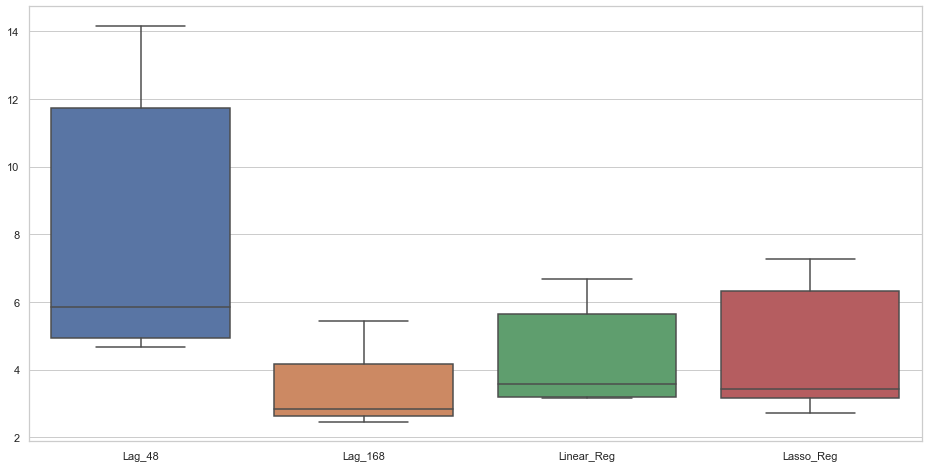

In [95]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,8))
sns.boxplot(data=mapes_df)
plt.show()

Considering the results, we can say that:
- The naive approach has a better performance with Lag168.
- Comparing linear regression and lasso regression; linear regression has a better performance but when it is compared with naive forecast with Lag 168, it performs worse.
- Naive forecast with Lag 168 seems as a better option for forecasting consumption compared to others.
- I was expecting to see that Lasso Regression performs better than others but it does not. This may be happened because of inefficient parameters or convergence parameters. 